# Intuition

We can have 2 kinds of predictions:

1. Given that the customer has not bought before, 
    1. Can we use their demographics to determine:
        1. How much (dollar amount) they will buy?
        2. How many items they will buy?
        3. What categories they will buy?
2. Given that the customer has made a purchase, 
    1. Can we see if their demographics, purchase history and purchase experience determine the likelihood of them returning?
        1. Compare the non-last transactions of repeat customers against transactions by single-time customers
    2. Can we compare past purchases to future ones? 
        1. E.g. to see if big spenders always spend big for all purchases. 
          Or those that buy from a certain category will continue to buy from that category. 
    3. Can we segment customers based on their purchase history? 
        1. Can also explore if particular segments have higher chance of returning customers. 
    
Can we segment customers based on what they purchase? E.g.:
* Those that purchase huge range of products
* Those that purchase only 1 item

# Import Data

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from pandas_profiling import ProfileReport
from tabulate import tabulate

from IPython.display import display, Markdown

sns.set(rc={'figure.figsize':(14, 6)})

from sklearn.metrics import precision_score, recall_score

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

In [620]:
customers = pd.read_csv("data/olist_customers_dataset.csv")
orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv").set_index('product_id')
products.product_category_name.fillna('others', inplace=True)
order_items = order_items.join(products, on='product_id').drop(['order_item_id'], axis=1)

for col in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
    orders[col] = pd.to_datetime(orders[col])
    
state_data = pd.read_csv("data/brazil_state_data.csv")
state_data.set_index('state', inplace=True)
state_data['gdp_per_capita'] = state_data['gdp'] / state_data['population']
customers = customers.join(state_data, on='customer_state')

orders = orders.merge(customers, on='customer_id').drop('customer_id', axis=1)

* GDP Data: https://agenciadenoticias.ibge.gov.br/en/agencia-press-room/2185-news-agency/releases-en/10155-gdp-of-municipalities-agriculture-represents-more-than-half-of-economic-activity-in-1-135-municipalities
* Population Data: https://en.wikipedia.org/wiki/List_of_Brazilian_federative_units_by_gross_regional_product 
* Size Data: http://www.brazil-help.com/brazilian_states.htm

# Data Preparation

In [621]:
orders['time_to_approve'] = (orders.order_approved_at - orders.order_purchase_timestamp).dt.total_seconds()
orders['time_to_ship'] = (orders.order_delivered_carrier_date - orders.order_approved_at).dt.total_seconds()
orders['time_to_reach'] = (orders.order_delivered_customer_date - orders.order_delivered_carrier_date).dt.total_seconds()
orders['days_delivery_diff'] = (orders.order_estimated_delivery_date - orders.order_delivered_customer_date).dt.days
orders['month_purchase'] = orders.order_purchase_timestamp.dt.month

In [622]:
orders['customer_num_order'] = orders.groupby('customer_unique_id')['order_purchase_timestamp'].rank()

In [623]:
max_num_orders = pd.DataFrame(customers.customer_unique_id.value_counts())
max_num_orders.columns = ['max_num_orders']

In [624]:
order_details = order_items.groupby('order_id').agg({'price': ['size', 'sum', 'mean'], 'freight_value': ['sum', 'mean'], 'product_id': ['nunique'], 'seller_id': ['nunique']})
cols = ['_'.join(col) for col in order_details.columns]
cols[0] = 'num_items'
order_details.columns = cols

In [625]:
order_reviews = reviews.groupby('order_id').agg({'review_score': ['size', 'mean']})
order_reviews.columns = ['num_reviews', 'avg_review']

In [626]:
orders = orders.join(max_num_orders, on='customer_unique_id').join(order_details, on='order_id').join(order_reviews, on='order_id')

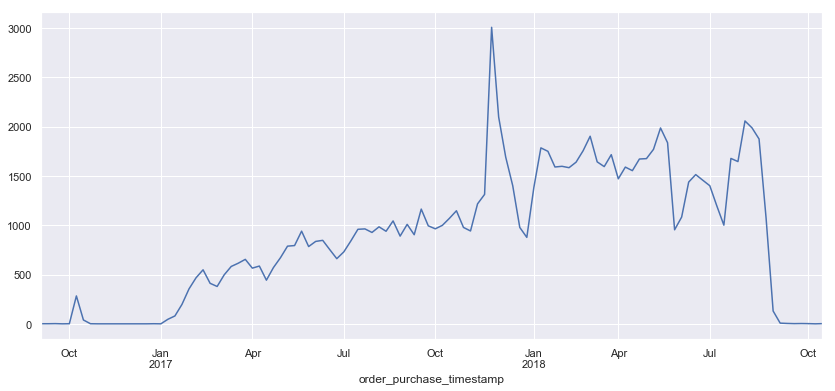

In [627]:
orders[['order_purchase_timestamp']].set_index('order_purchase_timestamp').resample('W').size().plot()

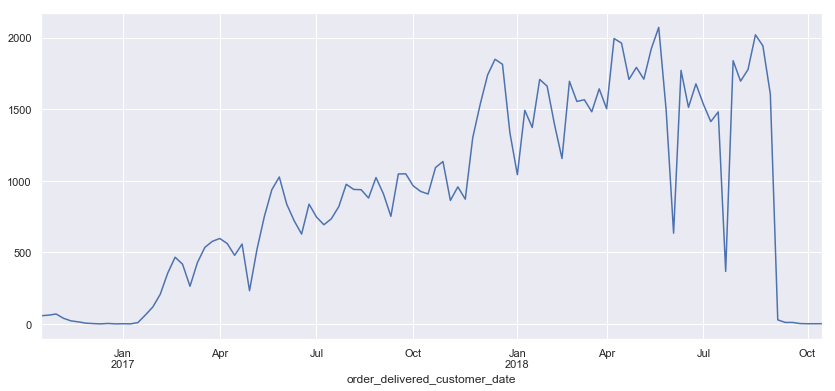

In [628]:
orders[['order_delivered_customer_date']].set_index('order_delivered_customer_date').resample('W').size().plot()

# Analysis

## Analysing All Customers

### Using Demographics to Predict Purchase Volume

In [103]:
orders[['price_sum', 'num_items', 'customer_state', 'gdp', 'size', 'population', 'customer_city', 'customer_zip_code_prefix']].head()

,price_sum,num_items,customer_state,gdp,size,population,customer_city,customer_zip_code_prefix
0,29.99,1.0,SP,628064882,248209,44035304,sao paulo,3149
1,118.70,1.0,BA,56624041,564692,15126371,barreiras,47813
2,159.90,1.0,GO,46094735,340086,6523222,vianopolis,75265
3,45.00,1.0,RN,19076030,52796,3408510,sao goncalo do amarante,59296
4,19.90,1.0,SP,628064882,248209,44035304,santo andre,9195


In [180]:
orders.shape

(99441, 31)

In [179]:
orders.dropna().shape

(96461, 31)

In [203]:
for y_col in ['price_sum', 'num_items', 'seller_id_nunique']:
    display(Markdown("# " + y_col))
    sub = orders[[y_col, 'gdp_per_capita', 'size']].dropna()
    X2 = sm.add_constant(sub.drop(y_col, axis=1))
    X2['gdp_per_capita'] = np.log1p(X2['gdp_per_capita'])
    X2['size'] = np.log1p(X2['size'])
    est = sm.OLS(np.log1p(sub[y_col]), X2)
    est2 = est.fit()
    display(est2.summary())

# price_sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_sum   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     180.5
Date:                Sun, 21 Apr 2019   Prob (F-statistic):           5.43e-79
Time:                        19:47:05   Log-Likelihood:            -1.3146e+05
No. Observations:               98666   AIC:                         2.629e+05
Df Residuals:                   98663   BIC:                         2.629e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.3417      0.052    102.081      0.000       5.239       5.444
gdp_per_capita    -0.1076      0.006    -18.230      0.000      -0.119      -0.096
size              -0.0513      0.004    -14.440      0.000      -0.058      -0.044
==============================================================================
Omnibus:                     1648.995   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1825.848
Skew:                           0.287   Prob(JB):                         0.00
Kurtosis:                       3.340   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# num_items

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              num_items   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.094
Date:                Sun, 21 Apr 2019   Prob (F-statistic):            0.00613
Time:                        19:47:05   Log-Likelihood:                 36477.
No. Observations:               98666   AIC:                        -7.295e+04
Df Residuals:                   98663   BIC:                        -7.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7157      0.010     75.021      0.000       0.697       0.734
gdp_per_capita     0.0032      0.001      2.975      0.003       0.001       0.005
size               0.0017      0.001      2.592      0.010       0.000       0.003
==============================================================================
Omnibus:                    80958.272   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1804788.576
Skew:                           3.975   Prob(JB):                         0.00
Kurtosis:                      22.386   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# seller_id_nunique

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seller_id_nunique   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.843
Date:                Sun, 21 Apr 2019   Prob (F-statistic):             0.0214
Time:                        19:47:05   Log-Likelihood:             1.5938e+05
No. Observations:               98666   AIC:                        -3.188e+05
Df Residuals:                   98663   BIC:                        -3.187e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6910      0.003    251.733      0.000       0.686       0.696
gdp_per_capita     0.0005      0.000      1.774      0.076   -5.76e-05       0.001
size               0.0005      0.000      2.753      0.006       0.000       0.001
==============================================================================
Omnibus:                   143547.669   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         33362668.484
Skew:                           9.143   Prob(JB):                         0.00
Kurtosis:                      91.210   Cond. No.                         225.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Using Demographics to Predict Purchase Items

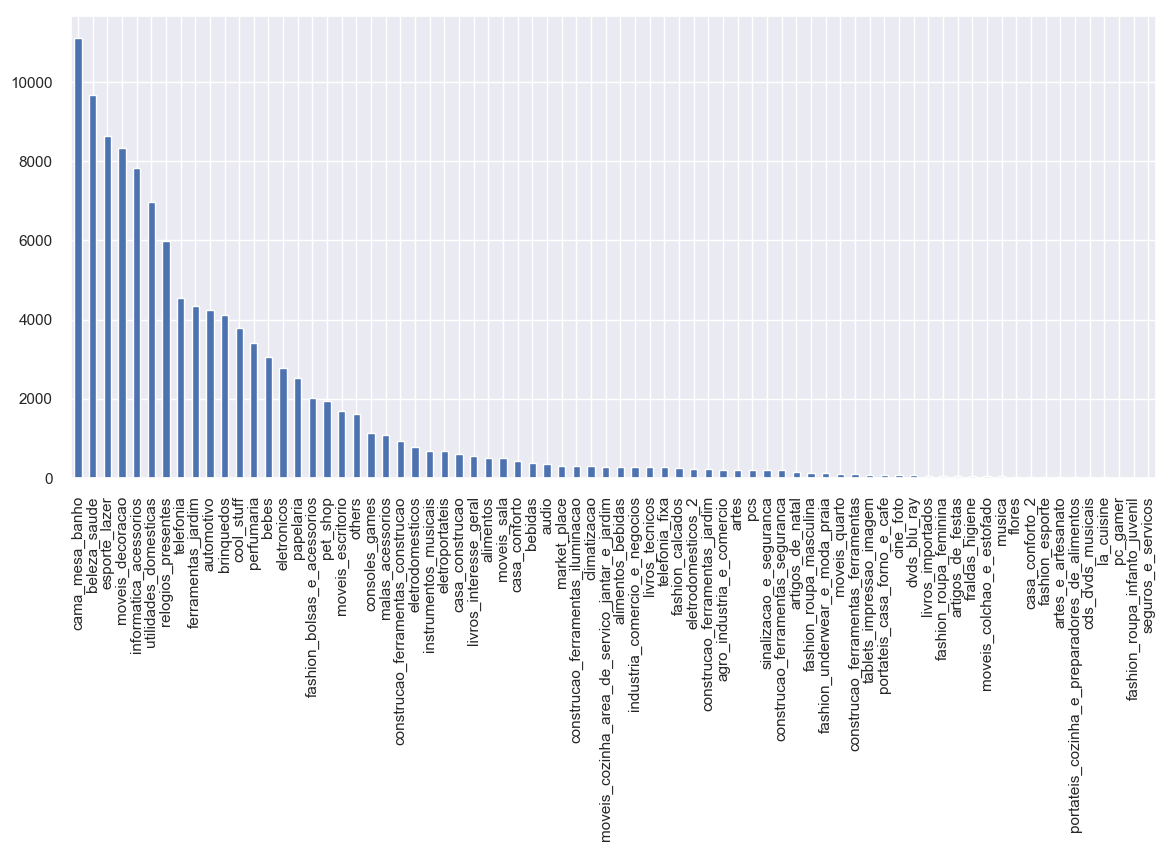

In [336]:
order_items.product_category_name.value_counts().plot(kind='bar')

In [630]:
first_n = 25
percent = order_items.product_category_name.value_counts()[:first_n].sum() / order_items.shape[0] * 100
display(Markdown("The first {} categories account for {:.2f}% of all orders. Let's convert the rest to \"others\".".format(first_n, percent)))

The first 25 categories account for 91.64% of all orders. Let's convert the rest to "others".

In [631]:
categories = pd.DataFrame(order_items.product_category_name.value_counts())
categories['product_category_name'] = categories.index
categories[first_n:]['product_category_name'] = 'others'

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [632]:
if 'product_category' in order_items.columns:
    order_items.drop('product_category', axis=1, inplace=True)
categories.columns = ['product_category']
order_items = order_items.join(categories, on='product_category_name')

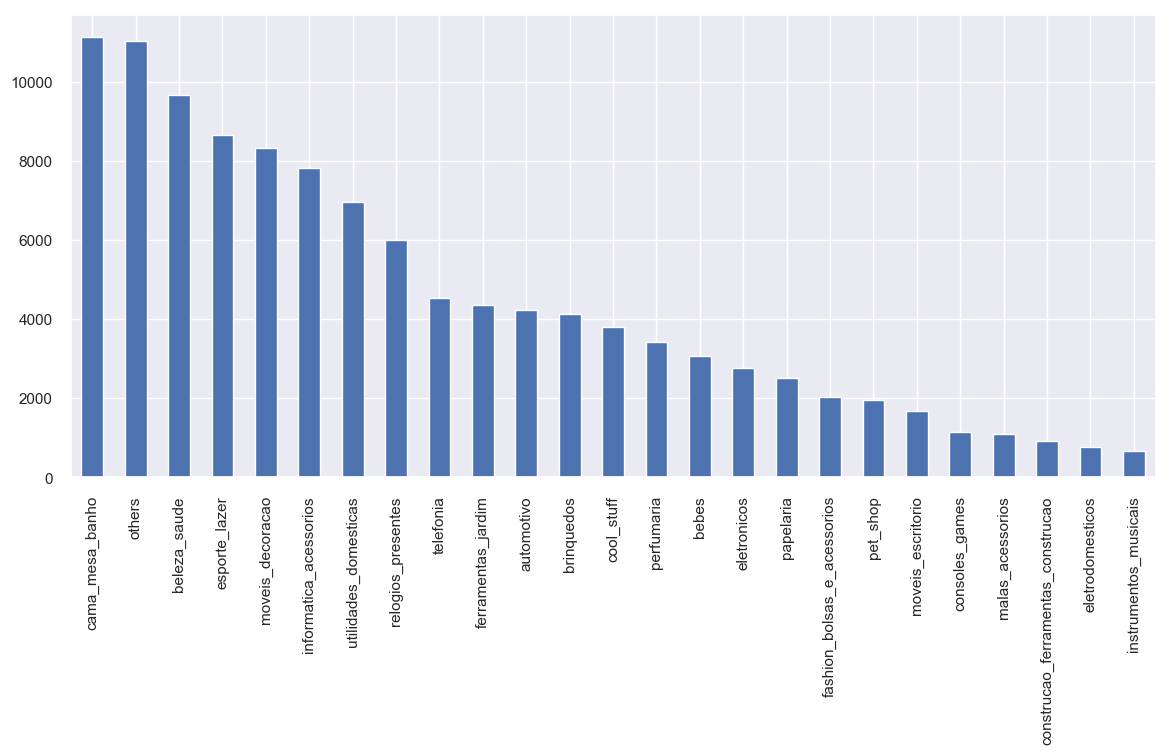

In [403]:
order_items.product_category.value_counts().plot(kind='bar')

In [404]:
subset = orders[['order_id', 'gdp_per_capita', 'gdp', 'population', 'size']].join(order_items.set_index('order_id'), on='order_id', how='right')[['product_category', 'gdp_per_capita', 'gdp', 'population', 'size']]

# gdp_per_capita

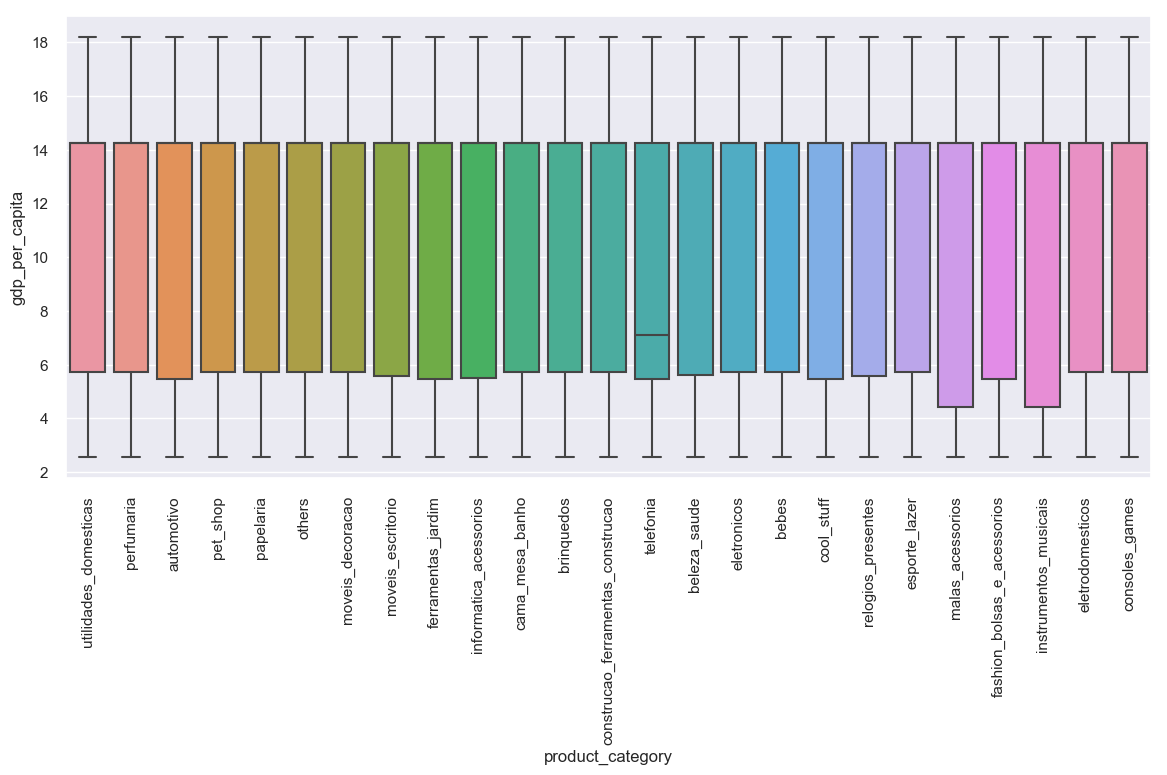

# gdp

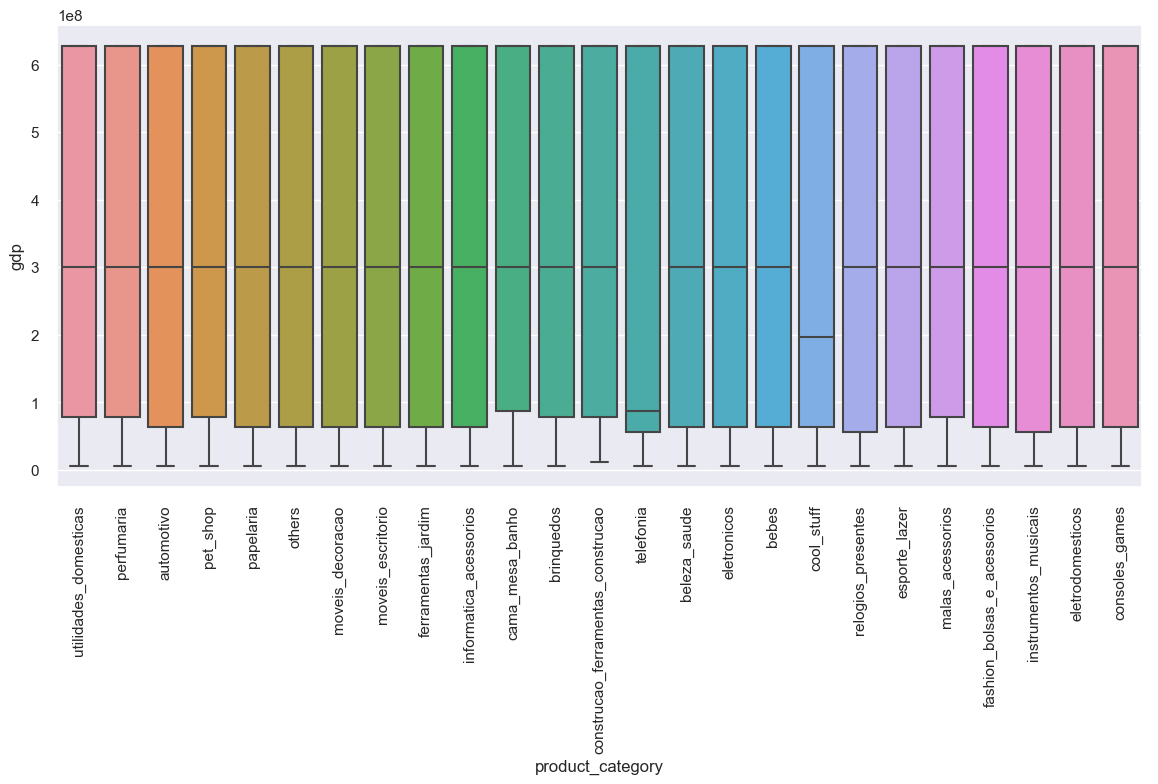

# population

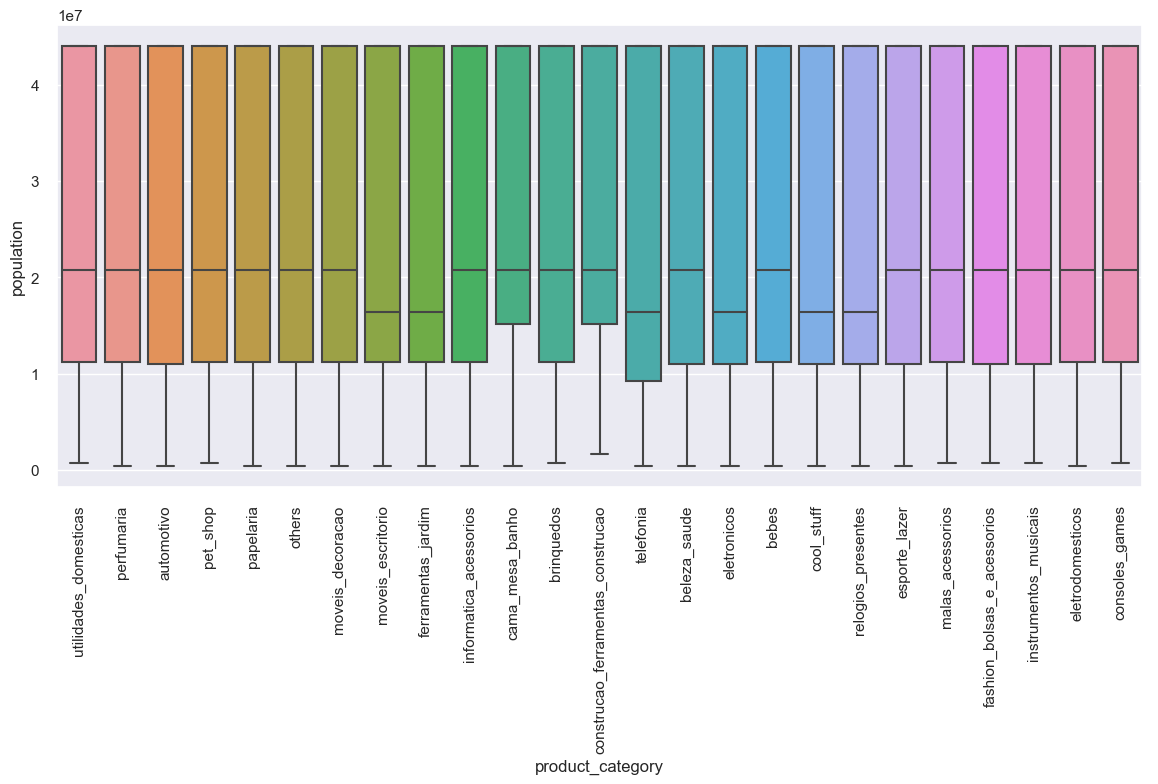

# size

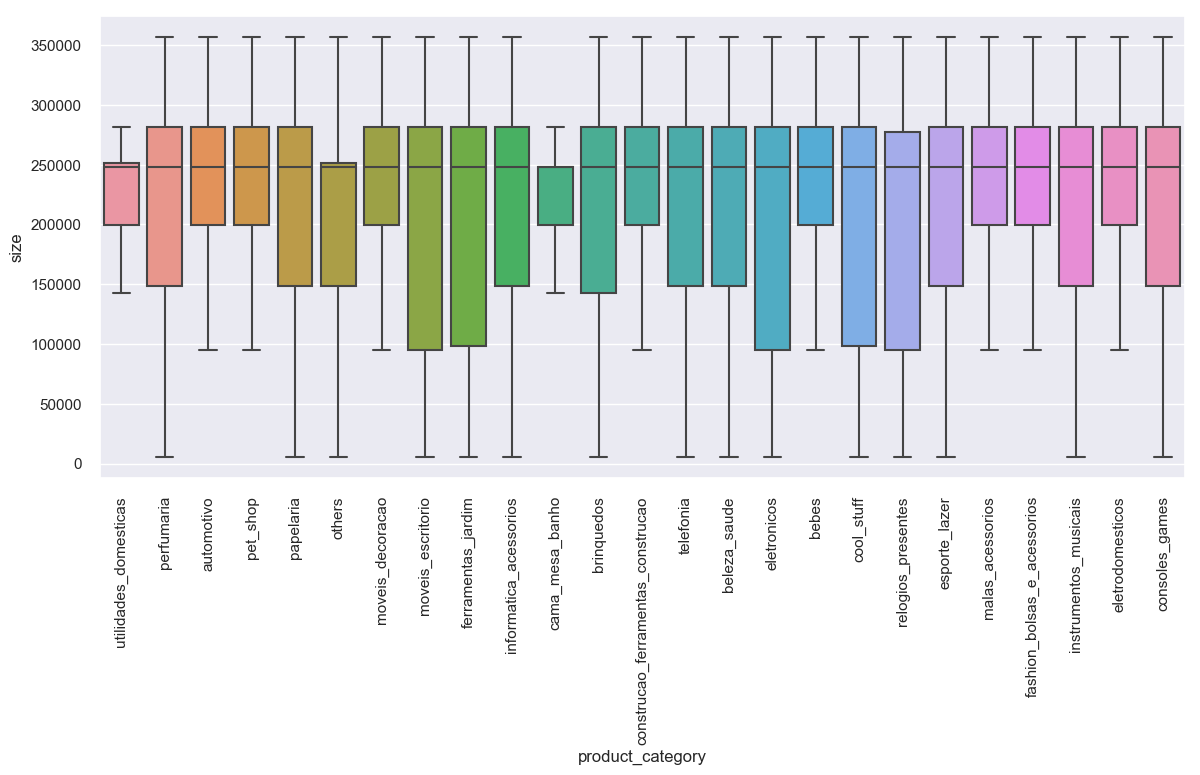

In [405]:
for col in ['gdp_per_capita', 'gdp', 'population', 'size']:
    display(Markdown("# " + col))
    sns.boxplot(subset.product_category, subset[col], showfliers=False)
    plt.xticks(rotation=90)
#     plt.yscale('log')
    plt.show()

## Analysing Return Customers

### See if demographics, purchase history and purchase experience determine the likelihood of customers returning

In [9]:
orders_filtered = orders[(orders.max_num_orders == 1) | ((orders.max_num_orders > 1) & (orders.max_num_orders > orders.customer_num_order))]

In [10]:
for month in range(1, 13):
    subset = orders_filtered[orders_filtered.month_purchase == month]
    print("Month{: 3}: {:.2f}% repeat customers".format(month, (subset.max_num_orders > 1).sum() / subset.shape[0] * 100))

Month  1: 4.26% repeat customers
Month  2: 4.65% repeat customers
Month  3: 3.70% repeat customers
Month  4: 3.15% repeat customers
Month  5: 3.50% repeat customers
Month  6: 3.19% repeat customers
Month  7: 3.59% repeat customers
Month  8: 2.97% repeat customers
Month  9: 5.50% repeat customers
Month 10: 4.46% repeat customers
Month 11: 3.99% repeat customers
Month 12: 3.44% repeat customers


Text(0, 0.5, '% of customers who return later on')

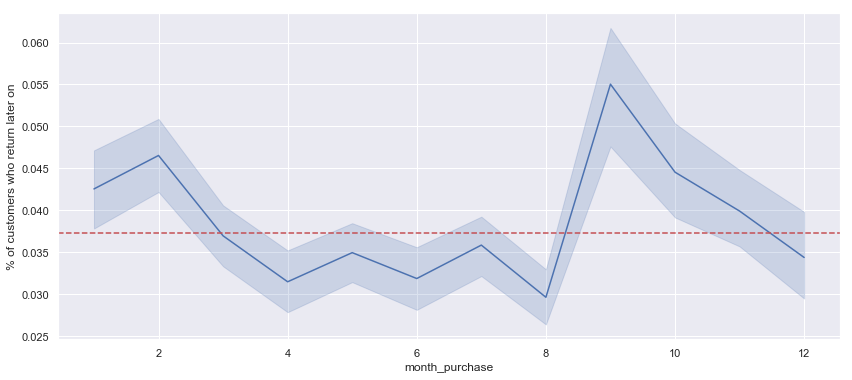

In [42]:
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")

From the above plot, we can see that there is a discernible difference in % of recurring customers for each month. 

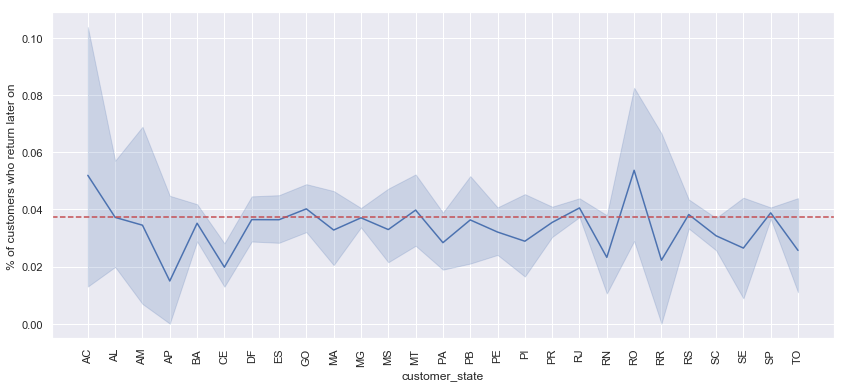

In [43]:
sns.lineplot(orders_filtered.customer_state, orders_filtered.max_num_orders > 1)
plt.axhline(y = (orders_filtered.max_num_orders > 1).sum() / orders_filtered.shape[0], color = 'r', linestyle='--')
plt.ylabel("% of customers who return later on")
_ = plt.xticks(rotation=90)

From the above plot, we can also see that there is a discernible difference in % of recurring customers for each state. 

In [89]:
# remove population (high correlation), size, gdp_per_capita, seller_id_nunique, avg_review (high p-value)

# subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
#         'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
#         'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
#         'num_reviews']]

subset = orders_filtered[['max_num_orders', 'gdp', 'time_to_approve', 
                          'size', 'gdp_per_capita', 'seller_id_nunique', 'avg_review',
                          'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
                          'num_items', 'price_sum', 'freight_value_mean', 'month_purchase', 
                          'num_reviews']]


for col in subset.columns:
    if (subset[col].isna().sum() > 0) and (subset[col].dtype == float or subset[col].dtype == int):
        subset[col] = subset[col].fillna(subset[col].mean())
        
for col in ['freight_value_sum', 'freight_value_mean', 'gdp_per_capita', 'num_items', 'price_sum', 'size', 'time_to_approve']:
    if col in subset.columns:
        subset[col] = np.log1p(subset[col])

subset['y'] = subset.max_num_orders > 1
subset.drop('max_num_orders', inplace=True, axis=1)

C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\yenter\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

In [170]:
def stepwise_regression(df, y):
    
    def process(cols):
        X = sm.add_constant(df[cols])
        model = sm.Logit(y, X).fit(disp = 0)
        pred_y = round(model.predict(X))
        return (model, pred_y)
    
    selected_columns = []
    available_columns = ['gdp', 'time_to_approve', 'size', 'gdp_per_capita', 'seller_id_nunique', 'avg_review',
        'time_to_ship', 'time_to_reach', 'days_delivery_diff', 
        'num_items', 'price_sum', 'freight_value_mean', 
        'num_reviews']
    best_score = 0
    best_pred_y = pd.Series()
    while len(selected_columns) < len(available_columns):
        col_to_add = None
        for col in available_columns:
            if col in selected_columns:
                continue
            # Build a model with each col
            X = sm.add_constant(df[selected_columns + [col]])
            model, pred_y = process(selected_columns + [col])
            recall = recall_score(y, pred_y)
            if recall > best_score:
                best_score = recall
                col_to_add = col
                best_pred_y = pred_y
            
        if col_to_add is None:
            # Couldn't find anything better
            X = sm.add_constant(df[selected_columns])
            model, pred_y = process(selected_columns)
            return (model, best_score, pred_y)
        else:
            selected_columns.append(col_to_add)
    X = sm.add_constant(df[selected_columns])
    model, pred_y = process(selected_columns)
    return (model, best_score, pred_y)

In [173]:
model, best_score, pred_y = stepwise_regression(subset.drop(['y', 'month_purchase'], axis=1), subset.y)
print("Recall: {:.3f}%".format(best_score * 100))

Recall: 8.937%


In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                96713
Model:                          Logit   Df Residuals:                    96711
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2019   Pseudo R-squ.:                 0.05656
Time:                        21:38:27   Log-Likelihood:                -14552.
converged:                       True   LL-Null:                       -15425.
                                        LLR p-value:                     0.000
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.0209      0.128    -62.857      0.000      -8.271      -7.771
num_reviews     4.6793      0.124     37.781      0.000       4.437       4.922
===============================================================================
"""

In [600]:
# ProfileReport(subset.drop('y', axis=1))

In [186]:
true_y = pd.Series()
pred_y = pd.Series()
month_recalls = []

for month in tqdm_notebook(range(1, 13)):
    X = subset[subset.month_purchase == month].drop(['y', 'month_purchase'], axis=1)
    y = subset[subset.month_purchase == month].y
    
    pred = round(model.predict(sm.add_constant(X[['num_reviews']])))
    true_y = true_y.append(y)
    pred_y = pred_y.append(pred)
    month_recalls.append(recall_score(y, pred) * 100)
    
#     model, best_score, pred_y_found = stepwise_regression(X, y)
#     true_y = true_y.append(y)
#     pred_y = pred_y.append(pred_y_found)
#     display(Markdown("# Month " + str(month)))
#     display(model.summary())
#     display(Markdown("Recall: {:.3f}%".format(best_score * 100)))
#     month_recalls.append(best_score * 100)

print("Precision: {: 7.3f}%".format(precision_score(true_y, pred_y) * 100))
print("Recall:    {: 7.3f}%".format(recall_score(true_y, pred_y) * 100))


Precision:  79.361%
Recall:      8.937%


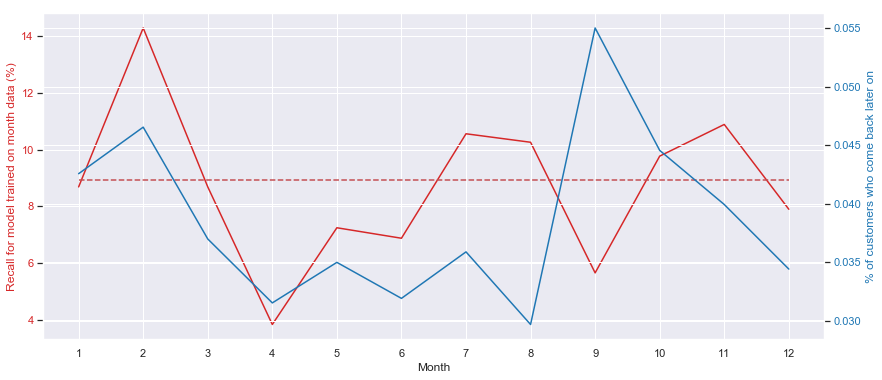

In [187]:
fig, ax1 = plt.subplots()
p = sns.lineplot(range(1, 13), month_recalls, ax=ax1, color='tab:red')
ax1.plot(range(1, 13), [recall_score(true_y, pred_y) * 100] * 12, 'r--')
ax1.set_xlabel("Month")
ax1.set_ylabel("Recall for model trained on month data (%)", color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')
_ = plt.xticks(range(1, 13))
ax2 = ax1.twinx()
sns.lineplot(orders_filtered.month_purchase, orders_filtered.max_num_orders > 1, err_style=None, ax=ax2, color='tab:blue')
ax2.set_ylabel("% of customers who come back later on", color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Clustering Customers

In [629]:
order_items_joined = orders.join(order_items.set_index('order_id'), on='order_id')[['customer_unique_id', 'product_category', 'price', 'freight_value']]
order_items_joined = pd.DataFrame(order_items_joined.groupby('customer_unique_id').progress_apply(lambda x: [list(y) for y in x.drop('customer_unique_id', axis=1).to_records(index=False)]))
order_items_joined.columns = ['purchases']

KeyError: "['product_category'] not in index"

In [331]:
customers_joined = customers.set_index('customer_unique_id').join(order_items_joined)

In [332]:
customers_joined

,customer_id,customer_zip_code_prefix,customer_city,customer_state,gdp,size,population,gdp_per_capita,purchases
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,SP,628064882,248209,44035304,14.262758,"[[cama_mesa_banho, 129.9, 12.0]]"
0000b849f77a49e4a4ce2b2a4ca5be3f,4cb282e167ae9234755102258dd52ee8,6053,osasco,SP,628064882,248209,44035304,14.262758,"[[beleza_saude, 18.9, 8.29]]"
0000f46a3911fa3c0805444483337064,9b3932a6253894a02c1df9d19004239f,88115,sao jose,SC,17328527,95346,6727148,2.575910,"[[papelaria, 69.0, 17.22]]"
0000f6ccb0745a6a4b88665a16c9f078,914991f0c02ef0843c0e7010c819d642,66812,belem,PA,28706165,1247689,8073924,3.555417,"[[telefonia, 25.99, 17.63]]"
0004aac84e0df4da2b147fca70cf8255,47227568b10f5f58a524a75507e6992c,18040,sorocaba,SP,628064882,248209,44035304,14.262758,"[[telefonia, 180.0, 16.89]]"
0004bd2a26a76fe21f786e4fbd80607f,4a913a170c26e3c8052ed0202849b5a8,5036,sao paulo,SP,628064882,248209,44035304,14.262758,"[[ferramentas_jardim, 154.0, 12.98]]"
00050ab1314c0e55a6ca13cf7181fecf,d2509c13692836fc0449e88cf9eb4858,13084,campinas,SP,628064882,248209,44035304,14.262758,"[[telefonia, 27.99, 7.39]]"
00053a61a98854899e70ed204dd4bafe,a81ebb9b32f102298c0c89635b4b3154,80410,curitiba,PR,78892229,199315,11081692,7.119150,"[[esporte_lazer, 191.0, 18.59], [esporte_lazer..."
0005e1862207bf6ccc02e4228effd9a0,3b37fb626fdf46cd99d37ec62afa88ff,25966,teresopolis,RJ,299849795,43696,16461173,18.215579,"[[fashion_bolsas_e_acessorios, 135.0, 15.12]]"


In [431]:
from sklearn.cluster import DBSCAN
import scipy.sparse
from progressbar import ProgressBar

In [421]:
def get_categories(purchases):
    result = set()
    for purchase in purchases:
        result.add(purchase[0])
    return result

In [633]:
num_customers = customers.shape[0]
num_customers = round(num_customers * 0.5) # if we get memory error from trying to build the full array

In [634]:
categories = {}

for i in tqdm_notebook(range(num_customers)):
    categories[i] = get_categories(customers_joined.iloc[i].purchases)

In [635]:
distances = np.zeros([num_customers, num_customers], np.float16)
bar = ProgressBar(max_value=(num_customers-1) * (num_customers) / 2)
count = 0
for i in range(num_customers-1):
    distances[i][i] = 1
    for j in range(i+1, num_customers):
        # calc distance
        # using jaccard index
        intersect = len(categories[i] & categories[j])
        if (intersect > 0):
            distance = intersect / len(categories[i] | categories[j])
            distances[i][j] = distance
            distances[j][i] = distance
    count += (num_customers - i - 2)
    bar.update(count)
bar.finish()

100% (1236014340.0 of 1236014340.0) |####| Elapsed Time: 0:06:48 Time:  0:06:48


In [636]:
distances = 1 - distances

In [640]:
clustering = DBSCAN(metric='precomputed').fit(distances)

C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
C:\Users\yenter\Anaconda3\lib\site-packages\numpy\core\_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


MemoryError: 

In [ ]:
pd.Series(clustering.labels_).value_counts()

# Random. 

Analysing sellers and products

In [337]:
order_items.product_id.nunique() / order_items.shape[0]

0.29250776742121615

In [377]:
tmp = order_items.join(orders.set_index('order_id'), on='order_id')

In [389]:
tmp[['seller_id', 'product_id']].drop_duplicates().groupby('product_id').size().sort_values(ascending=False).head()

product_id
d285360f29ac7fd97640bf0baef03de0    8
69455f41626a745aea9ee9164cb9eafd    8
4298b7e67dc399c200662b569563a2b2    7
36f60d45225e60c7da4558b070ce4b60    7
656e0eca68dcecf6a31b8ececfabe3e8    7
dtype: int64

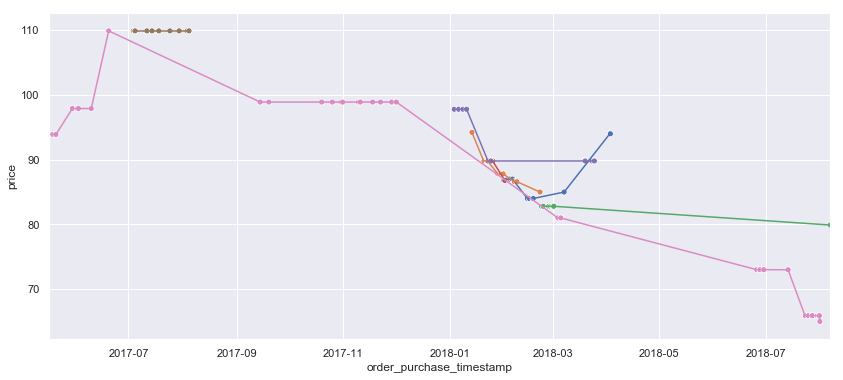

In [396]:
t = tmp[['order_purchase_timestamp', 'seller_id', 'product_id', 'price']].drop_duplicates()
t = t[t.product_id == '656e0eca68dcecf6a31b8ececfabe3e8'].sort_values(['seller_id', 'order_purchase_timestamp'])
sns.lineplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
sns.scatterplot(t.order_purchase_timestamp, t.price, hue=t.seller_id)
plt.xlim(t.order_purchase_timestamp.min(), t.order_purchase_timestamp.max())
plt.legend().remove()

In [343]:
order_items[['product_id']].drop_duplicates().shape[0]

32951

In [344]:
products.shape

(32951, 8)

# Others

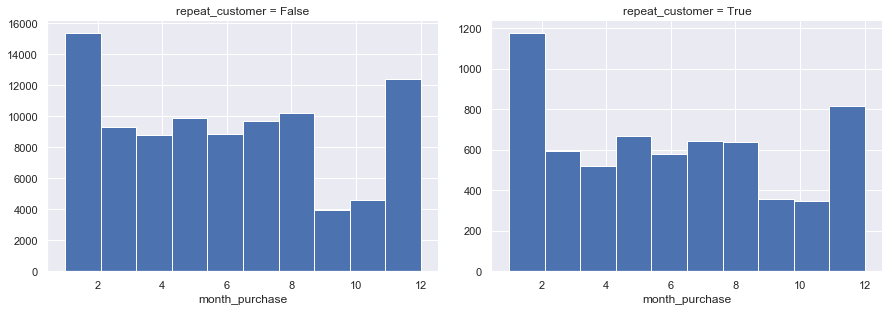

In [170]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "month_purchase")

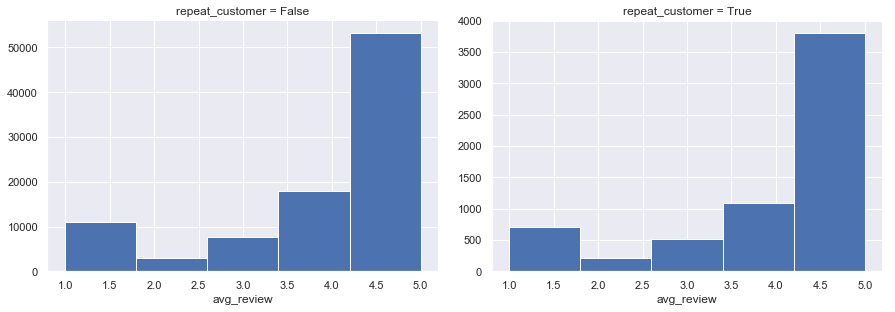

In [180]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "avg_review", bins=5)

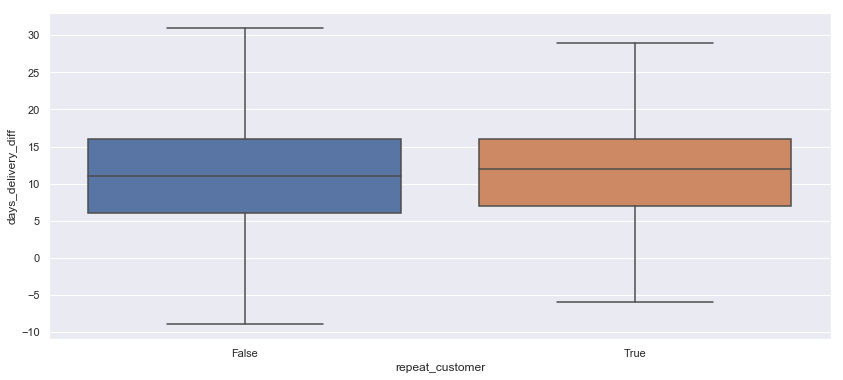

In [197]:
sns.boxplot(orders.repeat_customer, orders.days_delivery_diff, showfliers=False)

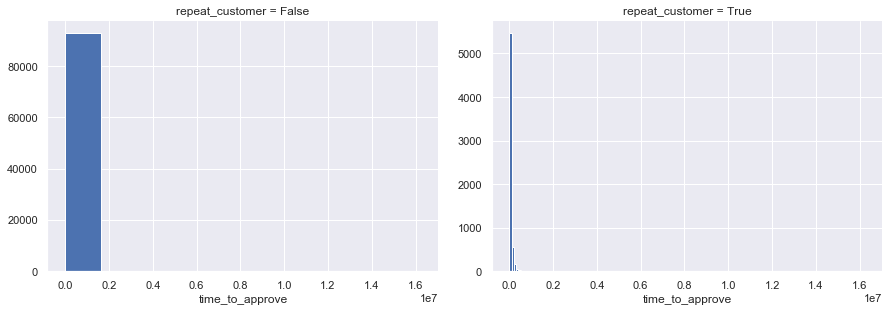

In [201]:
g = sns.FacetGrid(orders, col='repeat_customer', sharey = False, height=4.5, aspect=1.4)
g = g.map(plt.hist, "time_to_approve")

In [222]:
orders['time_to_approve_bins'] = pd.qcut(orders.time_to_approve, 10)

In [246]:
results = []
for category in orders['time_to_approve_bins'].cat.categories:
    sub = orders[orders.time_to_approve_bins == category]
    results.append([category, "{0:.3f}".format(sub.repeat_customer.sum() / sub.shape[0] * 100)])
print(tabulate(results, headers=('time_to_approve', '% repeat')))

time_to_approve           % repeat
----------------------  ----------
(-0.001, 605.0]              6.846
(605.0, 721.0]               6.821
(721.0, 832.0]               6.767
(832.0, 978.0]               6.12
(978.0, 1236.0]              6.471
(1236.0, 2214.0]             5.623
(2214.0, 21798.0]            6.487
(21798.0, 76783.0]           6.104
(76783.0, 124775.0]          5.852
(124775.0, 16233050.0]       6.144


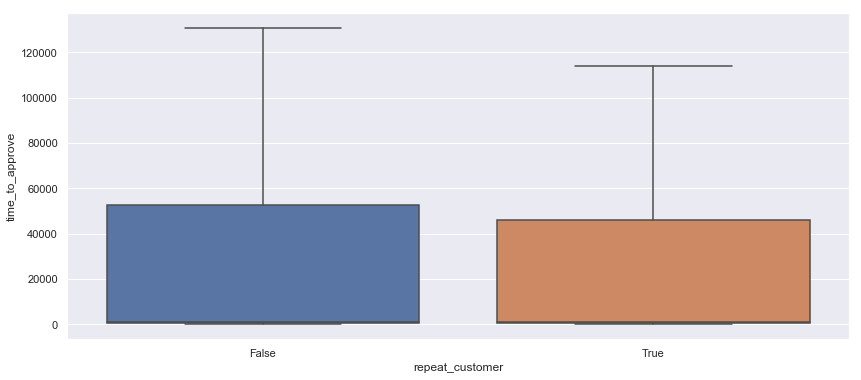

In [200]:
sns.boxplot(orders.repeat_customer, orders.time_to_approve, showfliers=False)